In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read Data
df = pd.read_csv('Customer-Churn-Records.csv')
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  Complain  SatisfactionScore CardType  PointEarned  
0        101348.88       1         1                  2  DIAMOND          464  
1        112542.58       0         1                  3  DIAMOND          456  
2        113931.57       1         1                  3  DIAMOND          377  
3         93826.63       0         0                  5     GOLD          350  
4         79084.10       0         0                  5     GOLD          425

# Data Preparation & Cleaning for Modeling

## Data Quality Check

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   RowNumber          10000 non-null  int64  
 1   CustomerId         10000 non-null  int64  
 2   Surname            10000 non-null  object 
 3   CreditScore        10000 non-null  int64  
 4   Geography          10000 non-null  object 
 5   Gender             10000 non-null  object 
 6   Age                10000 non-null  int64  
 7   Tenure             10000 non-null  int64  
 8   Balance            10000 non-null  float64
 9   NumOfProducts      10000 non-null  int64  
 10  HasCrCard          10000 non-null  int64  
 11  IsActiveMember     10000 non-null  int64  
 12  EstimatedSalary    10000 non-null  float64
 13  Exited             10000 non-null  int64  
 14  Complain           10000 non-null  int64  
 15  SatisfactionScore  10000 non-null  int64  
 16  CardType           1000

In [4]:
# Cek Duplikat
df.duplicated().sum()

np.int64(0)

In [5]:
# Cek Outlier
df_cek_outlier = df.select_dtypes(include=['float', 'int'])
#df_cek_outlier.drop(columns = ['RowNumber', 'CustomerId', 'HasCrCard', 'IsActiveMember', 'Exited', 'Complain'], inplace=True)
df_cek_outlier.plot(subplots=True, layout=(4,4), kind='box', figsize=(12,14))
plt.subplots_adjust(wspace=0.5);

# Data Splitting

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# Split data menjadi df_train (60%), df_valid (20%), dan df_test (20%)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_valid = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [8]:
df_train.shape, df_valid.shape, df_test.shape

((6000, 18), (2000, 18), (2000, 18))

# Preprocessing Data

Pilih fitur yang akan digunakan dalam modeling, kecualikan juga fitur target "Exited" dan fitur "Complain" (menyebabkan leakage)

In [9]:
df_col = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
          'IsActiveMember', 'EstimatedSalary', 'SatisfactionScore', 'CardType', 'PointEarned']

In [10]:
df_train_final = df_train[df_col]
df_valid_final = df_valid[df_col]
df_test_final = df_test[df_col]

Transformasi fitur CardType dari kategorikal (ordinal) menjadi numerik

In [11]:
df_train_final['CardType'].unique()

array(['SILVER', 'DIAMOND', 'PLATINUM', 'GOLD'], dtype=object)

In [12]:
card_type = {'SILVER':1, 'GOLD':2, 'PLATINUM':3, 'DIAMOND':4}

In [13]:
df_train_final['CardType'] = df_train_final['CardType'].map(card_type)
df_valid_final['CardType'] = df_valid_final['CardType'].map(card_type)
df_test_final['CardType'] = df_test_final['CardType'].map(card_type)

In [14]:
df_train_final.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
4495          789    France  Female   32       7   69423.52              1   
6470          583   Germany  Female   41       5   77647.60              1   
2221          767   Germany  Female   35       6  132253.22              1   
7686          718    France    Male   48       9       0.00              2   
9419          686   Germany    Male   26       1   57422.62              1   

      HasCrCard  IsActiveMember  EstimatedSalary  SatisfactionScore  CardType  \
4495          1               0        107499.39                  2         1   
6470          1               0        190429.52                  2         4   
2221          1               0        115566.57                  4         1   
7686          1               1         72105.63                  2         4   
9419          1               1         79189.40                  1         1   

      PointEarned  
4495          666  
6470          866  
2221          704  
7686          573  
9419          612

Transformasi fitur Geography dan Gender dari kategorikal (nominal) menjadi numerik

In [15]:
from sklearn.feature_extraction import DictVectorizer

In [16]:
dv = DictVectorizer(sparse=False)

In [17]:
df_train_final_dict = df_train_final.to_dict(orient='records')
df_valid_final_dict = df_valid_final.to_dict(orient='records')
df_test_final_dict = df_test_final.to_dict(orient='records')

In [18]:
df_train_final_dict = dv.fit_transform(df_train_final_dict)
df_valid_final_dict = dv.transform(df_valid_final_dict)
df_test_final_dict = dv.transform(df_test_final_dict)

In [19]:
df_train_final = pd.DataFrame(df_train_final_dict, columns = dv.get_feature_names_out())
df_valid_final = pd.DataFrame(df_valid_final_dict, columns = dv.get_feature_names_out())
df_test_final = pd.DataFrame(df_test_final_dict, columns = dv.get_feature_names_out())

In [20]:
df_train_final.head()

Age    Balance  CardType  CreditScore  EstimatedSalary  Gender=Female  \
0  32.0   69423.52       1.0        789.0        107499.39            1.0   
1  41.0   77647.60       4.0        583.0        190429.52            1.0   
2  35.0  132253.22       1.0        767.0        115566.57            1.0   
3  48.0       0.00       4.0        718.0         72105.63            0.0   
4  26.0   57422.62       1.0        686.0         79189.40            0.0   

   Gender=Male  Geography=France  Geography=Germany  Geography=Spain  \
0          0.0               1.0                0.0              0.0   
1          0.0               0.0                1.0              0.0   
2          0.0               0.0                1.0              0.0   
3          1.0               1.0                0.0              0.0   
4          1.0               0.0                1.0              0.0   

   HasCrCard  IsActiveMember  NumOfProducts  PointEarned  SatisfactionScore  \
0        1.0             0.0            1.0        666.0                2.0   
1        1.0             0.0            1.0        866.0                2.0   
2        1.0             0.0            1.0        704.0                4.0   
3        1.0             1.0            2.0        573.0                2.0   
4        1.0             1.0            1.0        612.0                1.0   

   Tenure  
0     7.0  
1     5.0  
2     6.0  
3     9.0  
4     1.0

# Modeling

Pendefinisian variabel x dan y

In [21]:
x_train = df_train_final
x_valid = df_valid_final
x_test = df_test_final

In [22]:
y_train = df_train['Exited']
y_valid = df_valid['Exited']
y_test = df_test['Exited']

## Model Selection & Evaluation

### Model Selection

**Logistic Regression**

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
model1 = LogisticRegression(random_state=42)
model1.fit(x_train, y_train)

LogisticRegression(random_state=42)

**Random Forest**

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
model2 = RandomForestClassifier(random_state=42)
model2.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

**SVM**

In [27]:
from sklearn.svm import SVC

In [28]:
model3 = SVC(probability=True, random_state=42)
model3.fit(x_train, y_train)

SVC(probability=True, random_state=42)

### Model Evaluation

In [29]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve

In [30]:
# Fungsi evaluasi
def evaluate_model(model, x_valid, y_valid, model_name=""):
    # Hitung probabilitas prediksi churn
    y_valid_prob = model.predict_proba(x_valid)[:, 1]
    
    # Cari threshold optimal berdasarkan F1 Score
    precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    # Prediksi dengan threshold optimal
    y_valid_pred = (y_valid_prob >= best_threshold).astype(int)

    # Hitung metrik evaluasi
    roc_auc = roc_auc_score(y_valid, y_valid_prob)
    precision = precision_score(y_valid, y_valid_pred)
    recall = recall_score(y_valid, y_valid_pred)
    f1 = f1_score(y_valid, y_valid_pred)

    # Mengembalikan hasil evaluasi dalam bentuk dictionary
    return {
        "Model": model_name,
        "ROC-AUC": round(roc_auc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3)
    }

In [31]:
# Pemanggilan Fungsi
# Daftar model yang akan dievaluasi (model, nama model)
models = [
    (model1, "Logistic Regression"),
    (model2, "Random Forest"),
    (model3, "SVM")
]

# Evaluasi setiap model dan simpan hasilnya dalam list of dict
results = [evaluate_model(model, x_valid, y_valid, name) for model, name in models]

# Ubah hasil evaluasi menjadi DataFrame untuk ditampilkan
df_results = pd.DataFrame(results)
print(df_results)

                 Model  ROC-AUC  Precision  Recall  F1 Score
0  Logistic Regression    0.665      0.349   0.519     0.417
1        Random Forest    0.834      0.633   0.589     0.610
2                  SVM    0.569      0.253   0.647     0.363


## Performance Stability Check

In [32]:
x_full_train = pd.concat([x_train, x_valid])
y_full_train = pd.concat([y_train, y_valid])

In [33]:
model = RandomForestClassifier(random_state=42)
model.fit(x_full_train, y_full_train)

RandomForestClassifier(random_state=42)

In [34]:
# Fungsi Evaluasi 
def evaluate_final_model(model, x_test, y_test, model_name=""):
    # Hitung probabilitas prediksi churn
    y_test_prob = model.predict_proba(x_test)[:, 1]

    # Cari threshold optimal berdasarkan F1 Score
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    best_idx = f1_scores.argmax()
    best_threshold = thresholds[best_idx]

    # Prediksi dengan threshold optimal
    y_test_pred = (y_test_prob >= best_threshold).astype(int)

    # Hitung metrik evaluasi
    roc_auc = roc_auc_score(y_test, y_test_prob)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # Mengembalikan hasil evaluasi dalam bentuk DataFrame
    result = pd.DataFrame([{
        "Model": model_name,
        "ROC-AUC": round(roc_auc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
    }])

    return result

In [35]:
# Pemanggilan fungsi evaluasi untuk satu model (Random Forest)
result_rf = evaluate_final_model(model, x_test, y_test, model_name="Random Forest")
print(result_rf)

           Model  ROC-AUC  Precision  Recall  F1 Score
0  Random Forest     0.87      0.614    0.68     0.645


# Feature Importance Analysis

In [36]:
import shap

In [37]:
# Menghitung SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

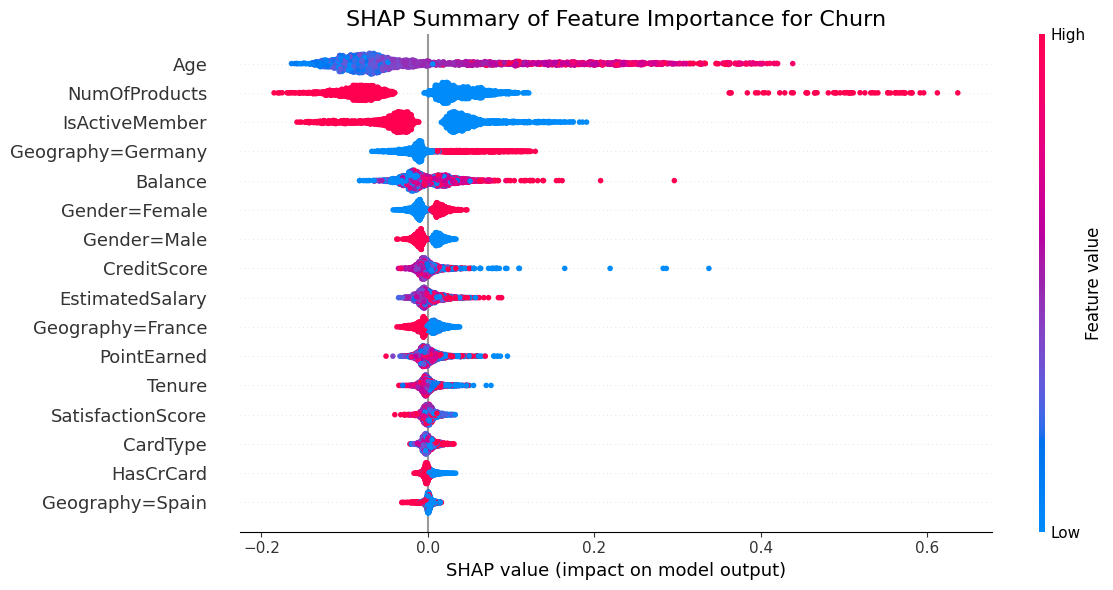

In [38]:
# Plot SHAP Summary
plt.title('SHAP Summary of Feature Importance for Churn', size=16)
shap.summary_plot(shap_values[:, :, 1], x_test, plot_size=[12,6])